$\Delta \epsilon/\epsilon_w$ [[0.6  0.06]]
[RLC_sensor] Initialized with:
  Lc = 8.000000000000001e-07 H
  Cp = 5e-13 F
  Self-capacitance = 0 F
  Total capacitance (C_total) = 5e-13 F
  RL = 40 Ω
  Rc = 100000000.0 Ω
  Z0 = 50 Ω
  R0 = 50000000.0 Ω
  g0 = 2e-08 S
  eps_w = 1 eV
  Resonant frequency (f0) = 2.516e+08 Hz
  Resonant period (T0) = 3.974e-09 s
  Capacitance noise model: OU_noise
Conductance per state (g/g0) :  [0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74

Sensor 0: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


[RLC_sensor] Initialized with:
  Lc = 8.000000000000001e-07 H
  Cp = 5e-13 F
  Self-capacitance = 0 F
  Total capacitance (C_total) = 5e-13 F
  RL = 40 Ω
  Rc = 100000000.0 Ω
  Z0 = 50 Ω
  R0 = 50000000.0 Ω
  g0 = 2e-08 S
  eps_w = 1 eV
  Resonant frequency (f0) = 2.516e+08 Hz
  Resonant period (T0) = 3.974e-09 s
  Capacitance noise model: OU_noise
Conductance per state (g/g0) :  [0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.74195893 0.35920132 0.74195893 0.35920132 0.74195893
 0.35920132 0.

Sensor 0: 100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


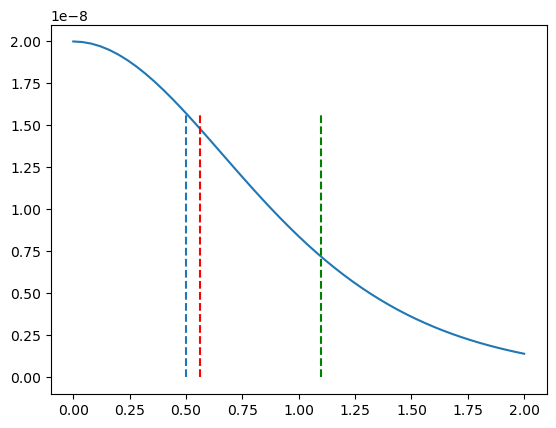

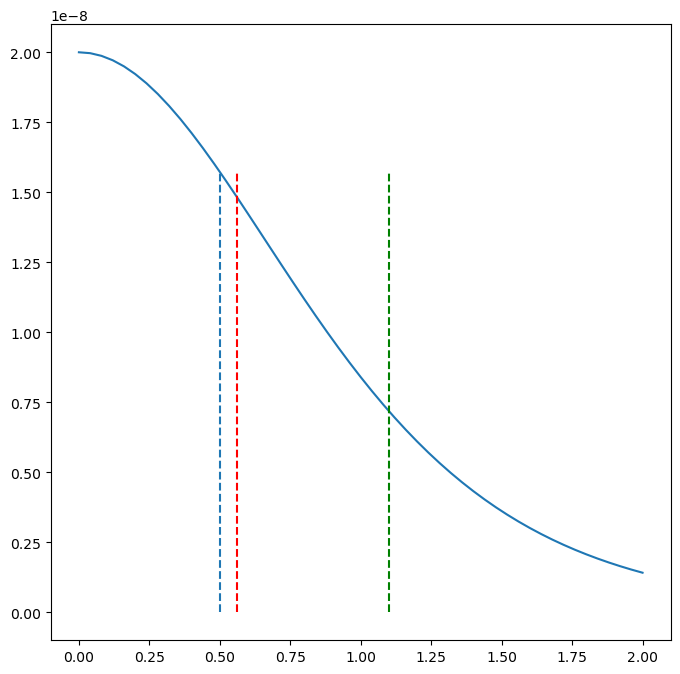

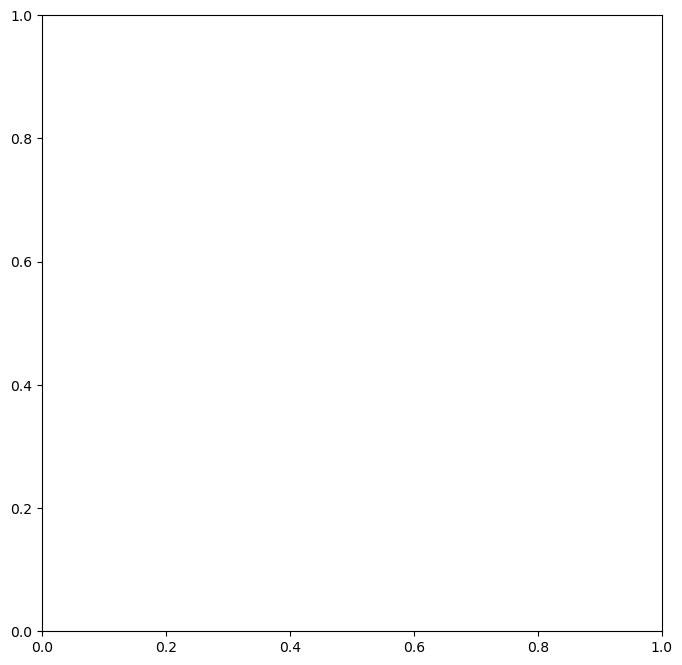

In [5]:
# src/readout_simulator/main.py
import sys
import os
import importlib
# Add the src directory to the Python path
sys.path.append(os.path.abspath('src'))



import numpy as np
import simulator as sm
import sensor_backend as sb
from noise_models import OverFNoise
import quantum_dot_system as qds

from noise import OU_noise # Added
importlib.reload(sm)
importlib.reload(sb)
importlib.reload(qds)




# DEFINITION OF QUANTUM DOT SYSTEM
deps_eps0 = 0.6 # shift in sensor detuning in the units of width eps_w
Cdd_2dot = np.array([[1, 0], [0, 1]])   # NOTE: Ndots x Ndots, diagonal->no cross-capacitance
Cds_2dot = np.array([[1], [0.1]])*deps_eps0   # NOTE: Nsensors x Ndots

dot_system = qds.QuantumDotSystem(Cdd_2dot, Cds_2dot)  #geometry



# --- Simulation Parameters ---
params = { 
    'SNR_white': 1e12,  #NOTE: better understanding of this parameter is needed
    'eps0': 0.5  # Nominal position on the Coulomb peak in the units width
}

nT_end = 2500 #periods of oscillation NOTE: with T0 = 4ns -> Tend = 10us
samples = 50 #samples
charge_states = [np.array([1, 0]), np.array([0, 1])]*samples # charge states to simulate, each state is repeated 'samples' times. Order matters if the noise if the capacitance/charge noise is corrlated.


params_resonator = {
    'Lc': 800*1e-9,  # Inductance of the resonator
    'Cp': 0.5*1e-12,  # Capacitance of the resonator
    'RL': 40,  # Resistance of the resonator
    'Rc': 100e6,  # Coupling resistance
    'Z0': 50      
    }
params_coulomb_peak = {
    "g0" : 1/50/1e6,   # Max conductance of coulomb peak RELATIVE UNITS
    "eps0" : 0.5,    # in relative to eps_width
    "eps_width" : 1, # NOTE: can be scapped as we use normalised units where eps = 1
}

#----------------- Clean simulator ----------------
eps_noise = OverFNoise(
                n_fluctuators=1, s1=1e-99, sigma_couplings=1e-99,
                ommax=1 / 1, ommin=1 / 5,
                dt=1, equally_dist = True
            )  #NOTE: dummy noise model TODO: allow NONE

c_noise = OU_noise(sigma=1e-99, gamma=1e7) #NOTE: dummy noise model, TODO: allow none
sensors = [sb.RLC_sensor(params_resonator, params_coulomb_peak, c_noise, eps_noise)]

simulator = sm.ReadoutSimulator(
    dot_system=dot_system, 
    sensors = sensors)


simulator.run_simulation(charge_states, nT_end, params)
IQ_clean, t = simulator.get_int_IQ()


# ---------------- Noisy simulator ----------------
eps_noise = OverFNoise(
                n_fluctuators=5, s1=1e-3, sigma_couplings=1e-99,
                ommax=1 / 1, ommin=1 / 5,
                dt=1, equally_dist = True
            ) # s1 is the amplitude
c_noise = OU_noise(sigma=1e-13, gamma=1e5)  # gamma is the 1/correlation time[ns]. Each measurment is 
sensors = [sb.RLC_sensor(params_resonator, params_coulomb_peak, c_noise, eps_noise)]

simulator2 = sm.ReadoutSimulator(
    dot_system=dot_system, 
    sensors=sensors
)

simulator2.run_simulation(charge_states, nT_end, params)
IQ_noisy, t2 = simulator2.get_int_IQ()



In [25]:
IQ_clean[0]["I"].shape

(50,)

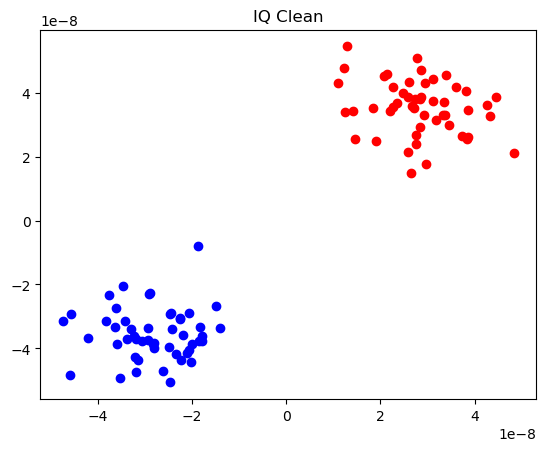

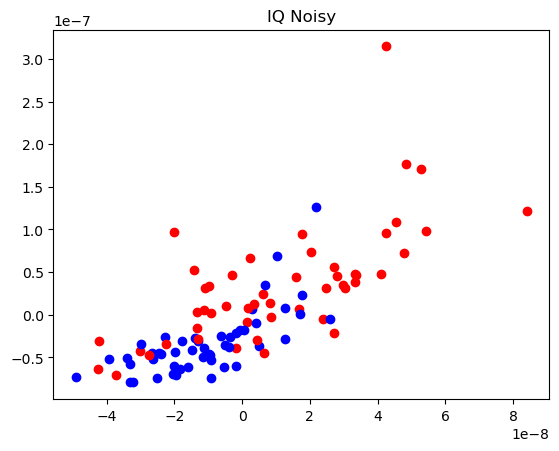

In [6]:
import matplotlib.pyplot as plt


Ic_mean = np.mean([IQ["I"] for IQ in IQ_clean], axis=0)
Qc_mean = np.mean([IQ["Q"] for IQ in IQ_clean], axis=0)
Ic_noisy_mean = np.mean([IQ["I"] for IQ in IQ_noisy], axis=0)
Qc_noisy_mean = np.mean([IQ["Q"] for IQ in IQ_noisy], axis=0    )

plt.title("IQ Clean")
for n, IQ in enumerate(IQ_clean):
    if n % 2 == 0:
        plt.scatter(IQ_clean[n]["I"][-1] - Ic_mean[-1], IQ_clean[n]["Q"][-1] - Qc_mean[-1], label='Clean IQ', color='blue')
    else:
        plt.scatter(IQ_clean[n]["I"][-1] - Ic_mean[-1], IQ_clean[n]["Q"][-1] - Qc_mean[-1], label='Clean IQ', color='red')

plt.figure()
plt.title("IQ Noisy")
for n, IQ in enumerate(IQ_noisy):
    if n % 2 == 0:
        plt.scatter(IQ_noisy[n]["I"][-100] - Ic_noisy_mean[-100], IQ_noisy[n]["Q"][-100] - Qc_noisy_mean[-100], label='Noisy IQ', color='blue')
    else:
        plt.scatter(IQ_noisy[n]["I"][-1] - Ic_noisy_mean[-1], IQ_noisy[n]["Q"][-1] - Qc_noisy_mean[-1], label='Noisy IQ', color='red')




(-5.341324582630591e-08, 5.341324582630591e-08)

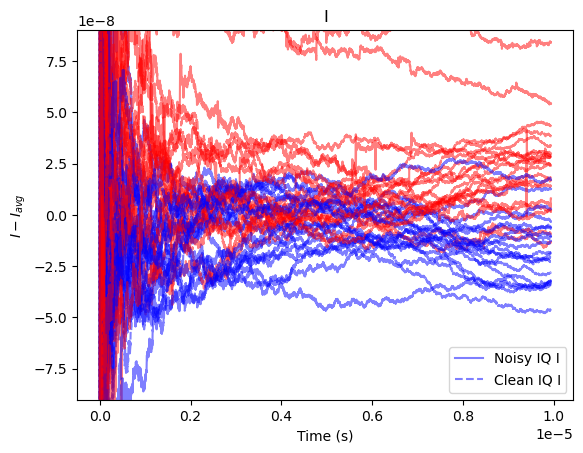

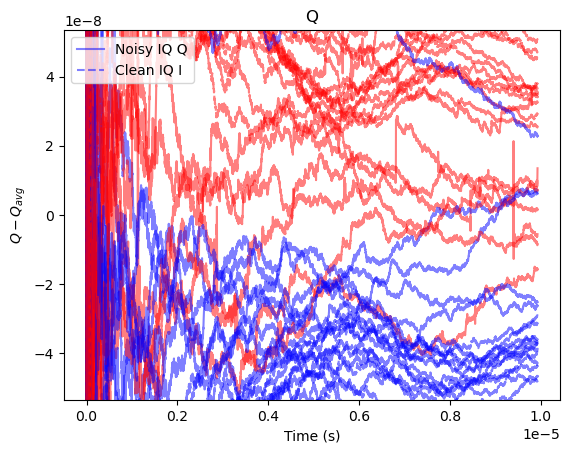

In [7]:
import matplotlib.pyplot as plt

Nplot = 20
plt.figure()
colors = ['blue', 'red' ]
for k in range(Nplot):
    plt.plot(t2, IQ_noisy[k]["I"] - Ic_noisy_mean, color=colors[k%2], alpha=0.5, label='Noisy IQ I' if k == 0 else "") 
    plt.plot(t2, IQ_clean[k]["I"] - Ic_mean, color=colors[k%2], linestyle='--', alpha=0.5,label='Clean IQ I' if k == 0 else "") 
plt.title("I")
plt.xlabel("Time (s)")
plt.ylabel("$I - I_{avg}$")
plt.legend()

zoomin = np.max(np.abs(IQ_noisy[k]["I"] - Ic_noisy_mean)[np.where(t2>2*1e-6)]) * 2
plt.ylim(-zoomin,zoomin)

plt.figure()
for k in range(Nplot):
    plt.plot(t2, IQ_noisy[k]["Q"] - Qc_noisy_mean, color=colors[k%2], alpha=0.5
                   , label='Noisy IQ Q' if k == 0 else "") 
    plt.plot(t2, IQ_clean[k]["Q"] - Qc_mean, color=colors[k%2], linestyle='--', alpha=0.5, label='Clean IQ I' if k == 0 else "") 
plt.title("Q")
plt.xlabel("Time (s)")
plt.ylabel("$Q - Q_{avg}$")
plt.legend()
zoomin = np.max(np.abs(IQ_noisy[k]["Q"] - Qc_noisy_mean)[np.where(t2>2*1e-6)]) * 2
plt.ylim(-zoomin,zoomin)





(0.0, 1e-08)

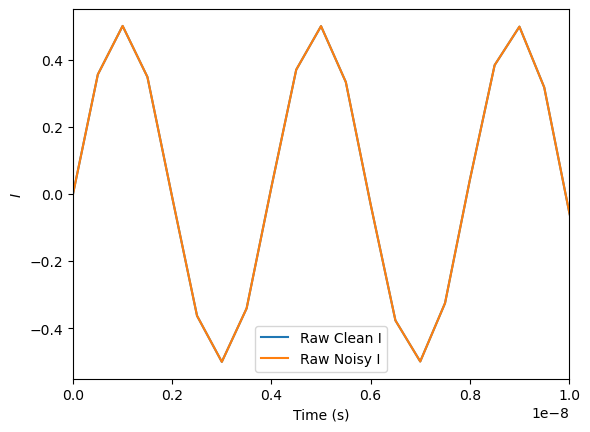

In [8]:
# plot raw signal
plt.figure()
raw_clean = simulator.get_raw_signal()
raw_noisy = simulator2.get_raw_signal()

plt.plot(t2, raw_clean[1][0], label='Raw Clean I')
plt.plot(t2, raw_clean[0][0], label='Raw Noisy I')
plt.xlabel("Time (s)")
plt.ylabel("$I$")
plt.legend()
plt.xlim(0,1e-8)


In [ ]:
Cdd_inv

array([[1.01209048e+17, 9.16536661e+15, 5.85023401e+15],
       [9.16536661e+15, 8.56084243e+16, 1.20904836e+16],
       [5.85023401e+15, 1.20904836e+16, 9.28237129e+16]])